In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend, test_beamline
from phase_space_reconstruction.virtual.scans import run_3d_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

In [2]:
# lattice and data directory
p0c = 43.36e6 # reference momentum in eV/c
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
data_dir = os.path.join('data', 'yaml_files')

In [3]:
# create gaussian and nongaussian beams using Bmad-X distgen functionality
gaussian_beam = create_beam(
    base_yaml = os.path.join(data_dir,'base.yaml'),
    transforms_yaml = os.path.join(data_dir,'transforms-linear.yaml'), 
    p0c = p0c,
    n_particle = 10_000
    )

nongaussian_beam = create_beam(
    base_yaml = os.path.join(data_dir,'base.yaml'),
    transforms_yaml = os.path.join(data_dir,'transforms-nonlinear.yaml'), 
    p0c = p0c,
    n_particle = 10_000
    )

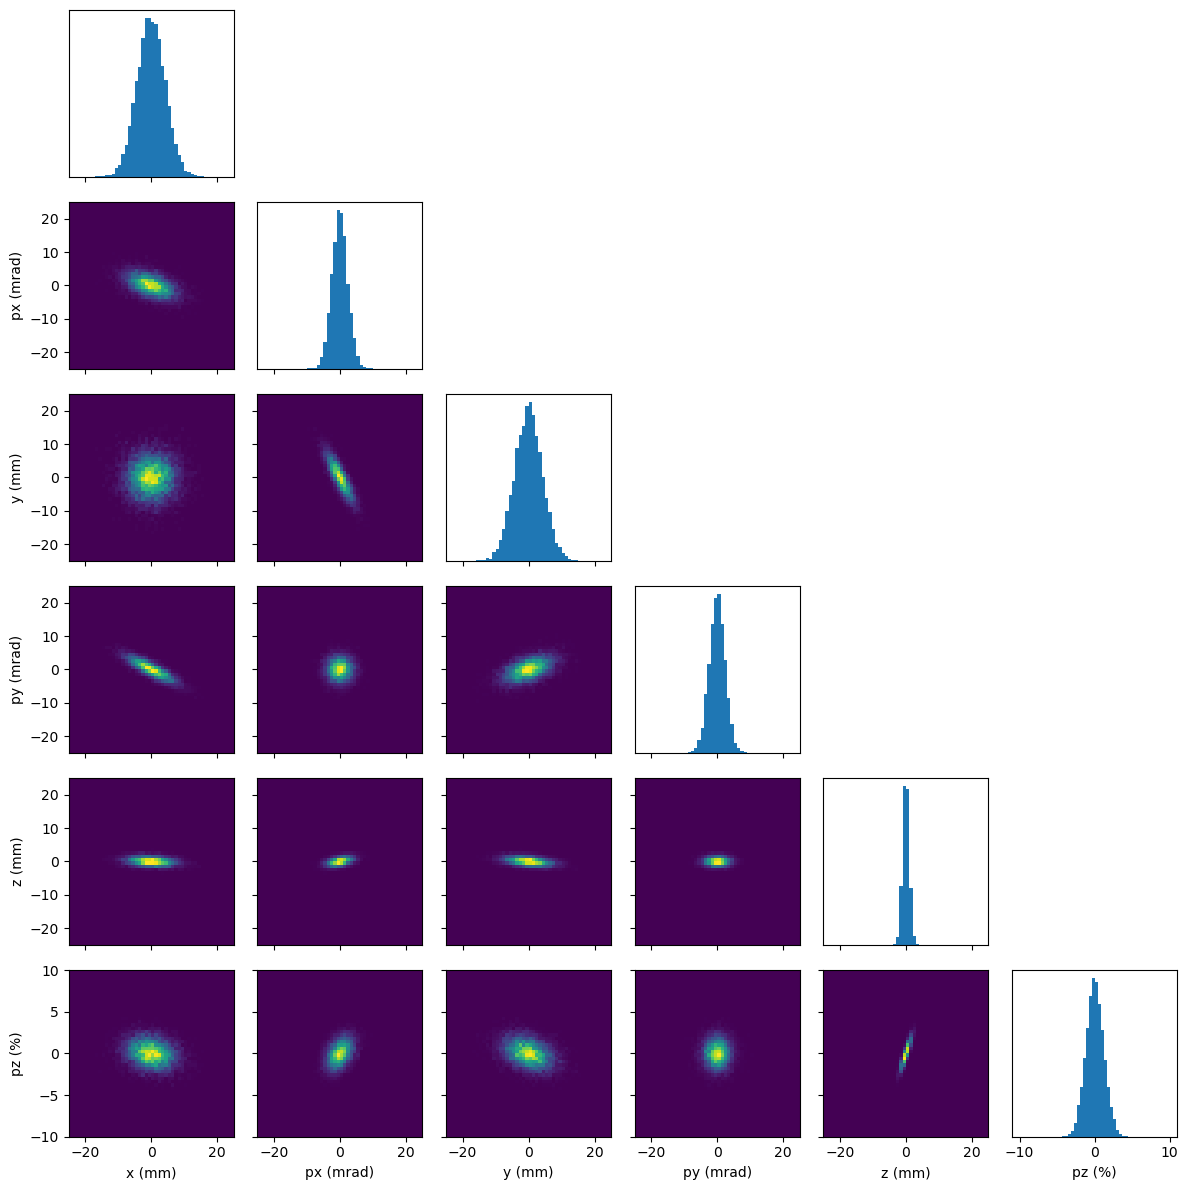

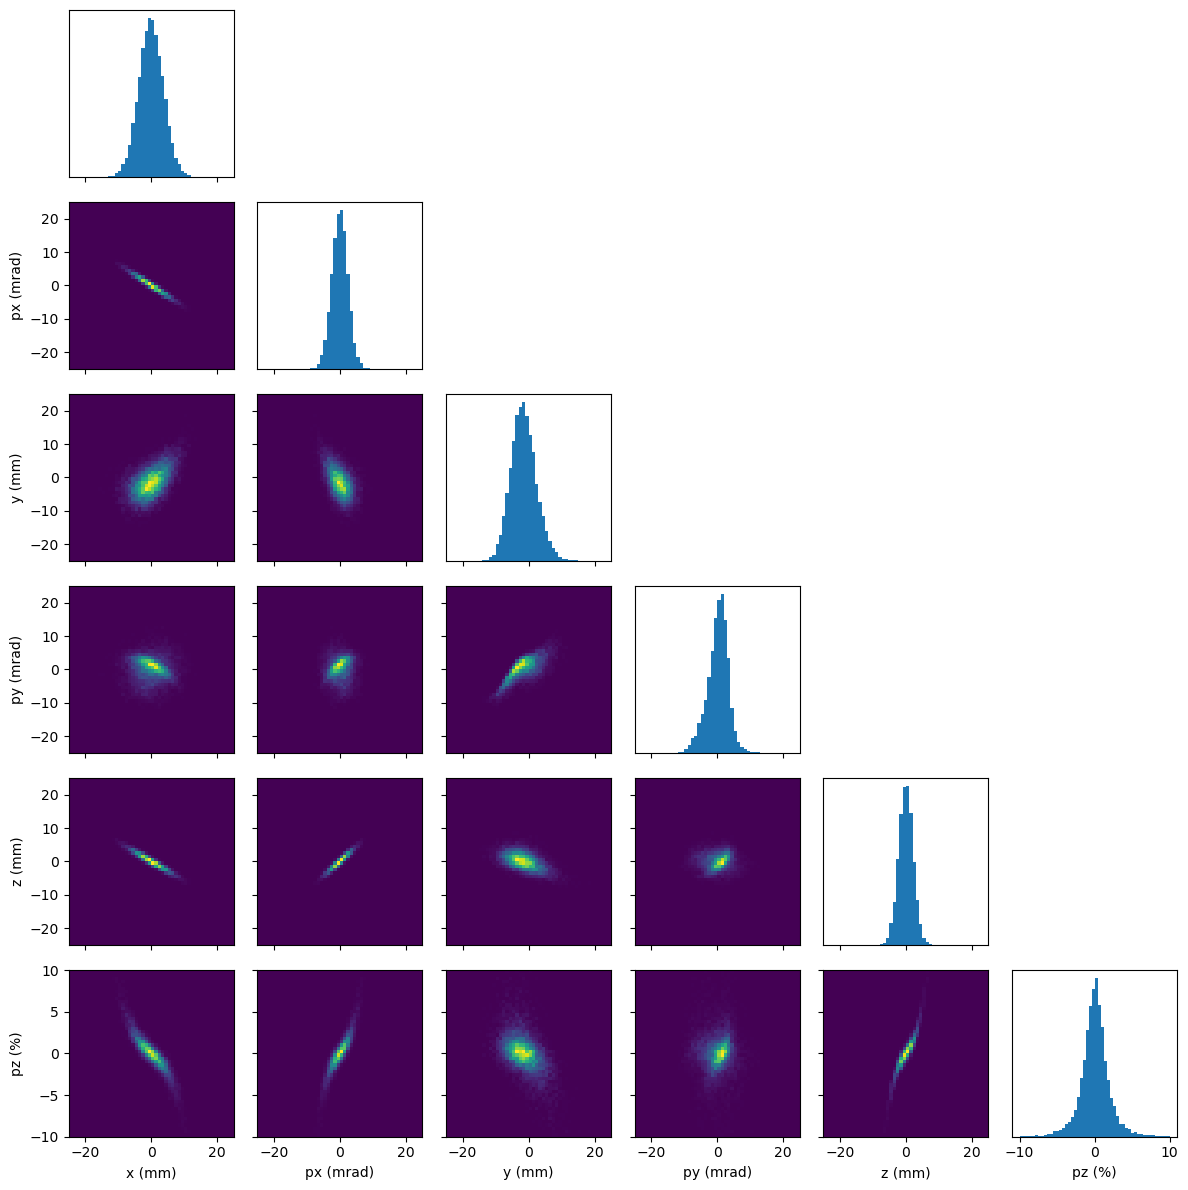

In [4]:
# plot linear and nonlinear beams
lims = np.array(
    [[-25e-3, 25e-3],
     [-25e-3, 25e-3],
     [-25e-3, 25e-3],
     [-25e-3, 25e-3],
     [-25e-3, 25e-3],
     [-10e-2, 10e-2]]
    )
fig, ax = plot_projections(gaussian_beam.numpy_particles(), custom_lims=lims)
plt.show()
fig, ax = plot_projections(nongaussian_beam.numpy_particles(), custom_lims=lims)
plt.show()

In [18]:
# use xopt for optimization
from triplet_opt import optimize_function, output
from xopt import VOCS

opt_vocs = VOCS(
        variables = {"k1":[0,20], "k2":[-20,0], "k3":[0,20]},
        objectives = {"total_size": "MINIMIZE"}
    )

opt_gaussian_beam = optimize_function(
    opt_vocs, output, n_iterations=100, 
    function_kwargs={
        'beam': gaussian_beam,
        'lattice': lattice
    }
)

opt_nongaussian_beam = optimize_function(
    opt_vocs, output, n_iterations=100, 
    function_kwargs={
        'beam': nongaussian_beam,
        'lattice': lattice
    }
)

In [19]:
# optimization results for linear beam
opt_gaussian_beam.data

,k1,k2,k3,std_x,std_y,total_size,xopt_runtime,xopt_error
1,10.019826,-3.285366,17.971734,0.018343,0.045280,0.047555,0.033212,False
2,7.446171,-8.216348,4.876783,0.007285,0.013708,0.014177,0.032432,False
3,10.789747,-1.776627,10.197716,0.016123,0.036524,0.038609,0.032317,False
4,6.031442,-10.963623,0.242113,0.008338,0.004930,0.008324,0.023145,False
5,1.152545,-9.649863,1.315047,0.010865,0.005315,0.010768,0.023714,False
...,...,...,...,...,...,...,...,...
99,1.228051,-19.389775,15.635451,0.004672,0.006668,0.006754,0.025538,False
100,18.684037,-2.586657,11.711247,0.021974,0.051335,0.054530,0.022844,False
101,17.431300,-0.058644,16.958302,0.023328,0.064983,0.067767,0.023447,False
102,17.788137,-1.888080,14.973269,0.022291,0.057722,0.060587,0.022848,False


In [20]:
opt_gaussian_beam.data.iloc[-1][["k1","k2", "k3"]]

k1     2.917415
k2        -20.0
k3    15.274649
Name: 103, dtype: object

In [21]:
# optimization results for nonlinear beam
opt_nongaussian_beam.data

,k1,k2,k3,std_x,std_y,total_size,xopt_runtime,xopt_error
1,8.702866,-1.405236,1.923902,0.011937,0.022821,0.024408,0.022873,False
2,7.986768,-4.811365,17.484506,0.015442,0.040206,0.041781,0.022766,False
3,10.495536,-14.847549,4.054061,0.006326,0.009144,0.009731,0.022759,False
4,11.662820,-18.211748,0.000000,0.004082,0.004260,0.004487,0.022601,False
5,7.128720,-20.000000,0.000000,0.004449,0.008081,0.007876,0.023376,False
...,...,...,...,...,...,...,...,...
99,1.156489,-13.471843,16.972566,0.006850,0.015108,0.015273,0.023119,False
100,9.947291,-5.492179,7.112639,0.012432,0.026280,0.027745,0.022655,False
101,0.172719,-14.735538,0.851779,0.008580,0.007158,0.009766,0.024289,False
102,13.897036,-7.538428,7.554067,0.014808,0.028815,0.031054,0.022645,False


In [22]:
opt_nongaussian_beam.data.iloc[-1][["k1","k2", "k3"]]

k1     7.985097
k2   -15.439955
k3          0.0
Name: 103, dtype: object